**Kindly add the SleevesClassificationCode folder from shared with me to My Drive**
---


# Linking the Google Drive with Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd "/content/drive/My Drive/SleevesClassificationCode"

/content/drive/My Drive/SleevesClassificationCode


In [ ]:
# # Unziping the dataset
# !unzip sleevesDataset.zip

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import os
import tensorflow as tf
import math
import random
import datetime
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
from keras.preprocessing import image
from PIL import ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output



---


# Reading Images

In [ ]:
base_tile_dir = 'sleeves'
paths=[]
for root, dirs, files in os.walk(base_tile_dir):
    for filename in dirs:
        for name in ['half','long_','threebyfour']:
          if name in filename:
            for nameImage in glob(os.path.join(base_tile_dir, filename,  '*.jpg')):
              paths.append(nameImage)


In [ ]:
df = pd.DataFrame(paths,columns =['path'])
df['image_name'] = df['path'].map(lambda x: os.path.basename(x).split('.')[0])
df['image'] = df['path'].map(imread)
className=list(df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1] ))
classTypeList=[]
for cName in className:
  for name in ['half','long','threebyfour']:
    if name in cName:
      classTypeList.append(name)
df['class_type'] = classTypeList
df.sample(5)

,path,image_name,image,class_type
529,sleeves/sleeves_halfsleeveshirt/pink (11).jpg,pink (11),"[[[254, 254, 254], [254, 254, 254], [254, 254,...",half
783,sleeves/sleeves_tshirtthreebyfourSleeve/11 (82...,11 (82),"[[[255, 255, 255], [255, 255, 255], [255, 255,...",threebyfour
754,sleeves/sleeves_tshirtthreebyfourSleeve/11 (53...,11 (53),"[[[247, 247, 247], [247, 247, 247], [247, 247,...",threebyfour
251,sleeves/sleeves_long_shirt/Shirt_ (31).jpg,Shirt_ (31),"[[[255, 255, 255], [255, 255, 255], [255, 255,...",long
701,sleeves/sleeves_tshirtthreebyfourSleeve/11 (13...,11 (135),"[[[255, 255, 255], [255, 255, 255], [255, 255,...",threebyfour


# Displaying an image from each class

sleeves/sleeves_long_shirt/Blue (67).jpg
sleeves/sleeves_halfsleeveshirt/black (16).jpg
sleeves/sleeves_tshirtthreebyfourSleeve/11 (1).jpg


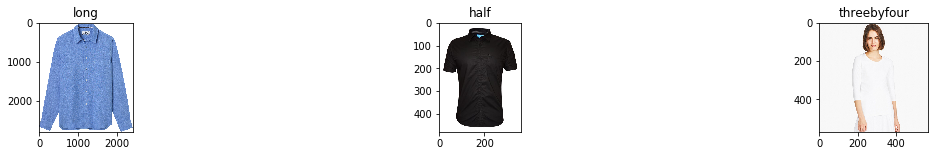

In [ ]:
def get_first_class_images(df):
    unique_class_type = df.class_type.unique()
    class_images = []
    for classt in unique_class_type:
        first_img_idx= np.where(df.class_type == classt)
        class_images.append((df[df.class_type == classt].loc[first_img_idx[0][1],'image'], classt,df[df.class_type == classt].loc[first_img_idx[0][1],'path']))
    return class_images

images = get_first_class_images(df)

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 2))
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])
    print(images[ii][2])


# Basic parameters for images

In [ ]:
img_size = 64
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size, num_channels)
num_classes = 3

# Converting images to tensor

In [ ]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(img_size,img_size))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

images_path = list(df.path)

images_tensors = paths_to_tensor(images_path)

images_tensors.shape

100%|██████████| 976/976 [00:11<00:00, 86.68it/s]


(976, 64, 64, 3)

# Splitting the data into train and test

In [ ]:
test_size = 0.2

encoder = LabelBinarizer()
actualLabels = encoder.fit_transform(df.class_type)
actualImages = images_tensors

X_train, X_test, Y_train, Y_test =\
    train_test_split(actualImages, actualLabels, test_size=test_size, random_state = 42)

# Displaying the shape of Training images and Testing images

In [ ]:
print('Training shape:', X_train.shape)
print(X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'x',X_train.shape[3] ,'size color image.\n')
print('Test shape:', X_test.shape)
print(X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'x',X_test.shape[3] ,'size color image.\n')

Training shape: (780, 64, 64, 3)
780 sample, 64 x 64 x 3 size color image.

Test shape: (196, 64, 64, 3)
196 sample, 64 x 64 x 3 size color image.



# Fetching the class labels

In [ ]:
Y_test_cls = np.argmax(Y_test, axis=1)
Y_train_cls = np.argmax(Y_train, axis=1)

# Reshaping the Images

In [ ]:
train_X = X_train
train_Y = Y_train
new_train_X = train_X.reshape(X_train.shape[0],img_size_flat)
new_test_X = X_test.reshape(X_test.shape[0],img_size_flat)



---


# Defining Model Parameters

In [ ]:
learning_rate = 0.001
training_iters = 40000
batch_size = 10
display_step = 20

n_input = img_size_flat
dropout = 0.75

In [ ]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

## Convolution Function

In [ ]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

## Maxpooling Function

In [ ]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

## Defining weights and biases

In [ ]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, num_channels, 32]),name='wc1'),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]),name='wc2'),
    'wd1': tf.Variable(tf.random_normal([64 * 64 * 4, 1024]),name='wd1'),
    'out': tf.Variable(tf.random_normal([1024, num_classes]),name='wout')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]),name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]),name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]),name='bd1'),
    'out': tf.Variable(tf.random_normal([num_classes]),name='bout')
}

## Defining the Model

In [ ]:
x_input = tf.reshape(x, [-1, img_size, img_size, num_channels])
# Convolution layer 1
conv1 = conv2d(x_input, weights['wc1'], biases['bc1'])
# Max pooling
conv1_1 = maxpool2d(conv1, k=2)
# Convolution layer 2
conv2 = conv2d(conv1_1, weights['wc2'], biases['bc2'])
# Max pooling
conv2_2 = maxpool2d(conv2, k=2)
# Fully connected layer
fc1 = tf.reshape(conv2_2, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
fc1 = tf.nn.relu(fc1)
fc1 = tf.nn.dropout(fc1, dropout)
# Last layer
out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# For evaluating model results
y_true_cls =  tf.argmax(y, 1)
y_pred_cls = tf.argmax(out, 1)
correct_model = tf.equal(y_pred_cls,y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_model, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()


## Function to create mini-batches

In [ ]:
def getBatch(X, Y, batchSize=10):
    arrayLength = X.shape[0]
    count = 0

    while count < arrayLength/batchSize:
        random.seed(datetime.datetime.now())
        randstart = random.randint(0, arrayLength-batchSize-1)
        count += 1
        yield (X[randstart:randstart+batchSize], Y[randstart:randstart+batchSize])


## Running the Model

In [ ]:
loss_t = []
steps_t = []
acc_t = []
sess = tf.Session()
sess.run(init)
step = 1
while step * batch_size < training_iters:
  a = getBatch(new_train_X,train_Y, batch_size)
  batch_x, batch_y = next(a)
  sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
  if step % display_step == 0:
    print('*'*15)
    loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                    y: batch_y,
                                                    keep_prob: 1.})
    print("Iter " + str(step*batch_size) + ", Loss= " + \
          "{:.3f}".format(loss) + ", Training Accuracy= " + \
          "{:.3f}".format(acc))
    loss_t.append(loss)
    steps_t.append(step*batch_size)
    acc_t.append(acc)
  step += 1

# Prediction on Test Images
cls_pred = sess.run(y_pred_cls, feed_dict={x: new_test_X,
                                           y: Y_test,
                                           keep_prob: 1.})

NameError: ignored



---


## Ploting the Training Loss

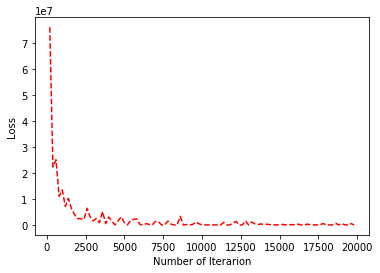

In [ ]:
plt.plot(steps_t, loss_t, 'r--')
plt.xlabel("Number of Iterarion")
plt.ylabel("Loss")
plt.show()

## Ploting the Training Accuracy

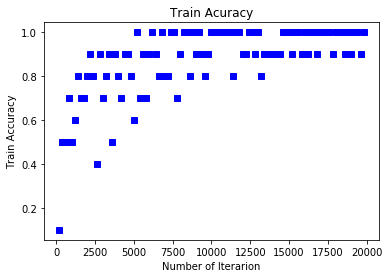

In [ ]:
plt.plot(steps_t, acc_t,'bs')
plt.title("Train Acuracy")
plt.xlabel("Number of Iterarion")
plt.ylabel("Train Accuracy")
plt.show()



---


## Accuracy on Test Images

In [ ]:
correct = (Y_test_cls == cls_pred)
correct_sum = correct.sum()
num_test = X_test.shape[0]
acc = float(correct_sum) / num_test
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, num_test))

Accuracy on Test-Set: 77.0% (151 / 196)




---


## Ploting Functions

In [ ]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape).astype('uint8') )

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images =new_test_X[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = Y_test_cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Ploting misclassified images

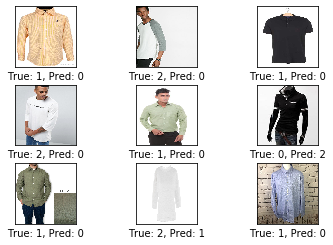

In [ ]:
plot_example_errors(cls_pred=cls_pred, correct=correct)



---


## Function to plot Confusion Matrix


In [ ]:
def plot_confusion_matrix(cls_pred):
    cls_true = Y_test_cls
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

[[65  5  4]
 [12 46  5]
 [13  6 40]]


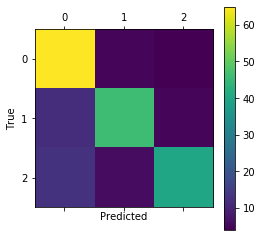

In [ ]:
plot_confusion_matrix(cls_pred=cls_pred)

---
## Code to display the Activition Map after a layer on an image
* Considered layer: first (i.e., conv2_2);
* Considered Image: First Training Image (i.e., X_train[0])
* White part in the image corresponds to the activation map


## Reading the Image and its label

[[1 0 0]]


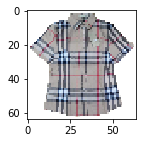

In [ ]:
imageToUse = X_train[1].astype('uint8')
imageToUse_label = Y_train[1].reshape((1, 3))
print(imageToUse_label)
plt.figure(figsize=(20,2))
plt.imshow(imageToUse)

## Fetch the predicted class

In [ ]:
cls_pred = sess.run(y_pred_cls, feed_dict={x: np.reshape(imageToUse,[1,img_size_flat],order='F'),
                                           y: imageToUse_label,
                                           keep_prob: 1.0})

## Function for Activition Map (Method: GRAD-CAM)

In [ ]:
def grad_cam(consideredImage, lastLayer_Model, sess, predicted_class, layerActivation, num_classes):
  conv_layer = layerActivation
  one_hot = tf.sparse_to_dense(predicted_class, [num_classes], 1.0)
  one_hot = tf.reshape(one_hot, [-1, num_classes])
  signal = tf.multiply(lastLayer_Model, one_hot)
  loss = tf.reduce_mean(signal)
  grads = tf.gradients(loss, conv_layer)[0]
  norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))
  output = sess.run(conv_layer, feed_dict={x: consideredImage, keep_prob: 1.0})
  grads_val = sess.run(norm_grads, feed_dict={x: consideredImage, keep_prob: 1.0})
  output = output[0]
  grads_val = grads_val[0]

  weights = np.mean(grads_val, axis = (0, 1))
  cam = np.ones(output.shape[0 : 2], dtype = np.float32)
  for i, w in enumerate(weights):
    cam += w * output[:, :, i]
  cam = np.maximum(cam, 0)
  cam = cam / np.max(cam)
  cam = resize(cam, (img_size, img_size))
  cam3 = np.expand_dims(cam, axis=2)
  cam3 = np.tile(cam3,[1,1,num_channels])

  return cam3

# Code to display the Activation Map


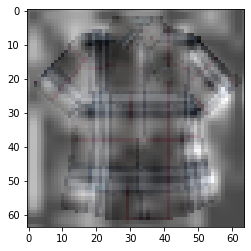

In [ ]:
imageToUse = imageToUse.reshape((1, img_size_flat))
consideredImage= imageToUse
lastLayer_Model = out
predicted_class=cls_pred
layerActivation=conv2_2
cam3 = grad_cam(consideredImage, lastLayer_Model, sess, predicted_class, layerActivation, num_classes)

img = X_train[1]
img /= img.max()

new_img = img+3*cam3
new_img /= new_img.max()

plt.imshow(new_img)

---
# Code to display the filters of a layer.
* Considered layer: first (i.e., conv1_1);
* Considered Image: First Training Image (i.e., X_train[1])


In [ ]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,img_size_flat],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [ ]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

## Calling the function to display the filters

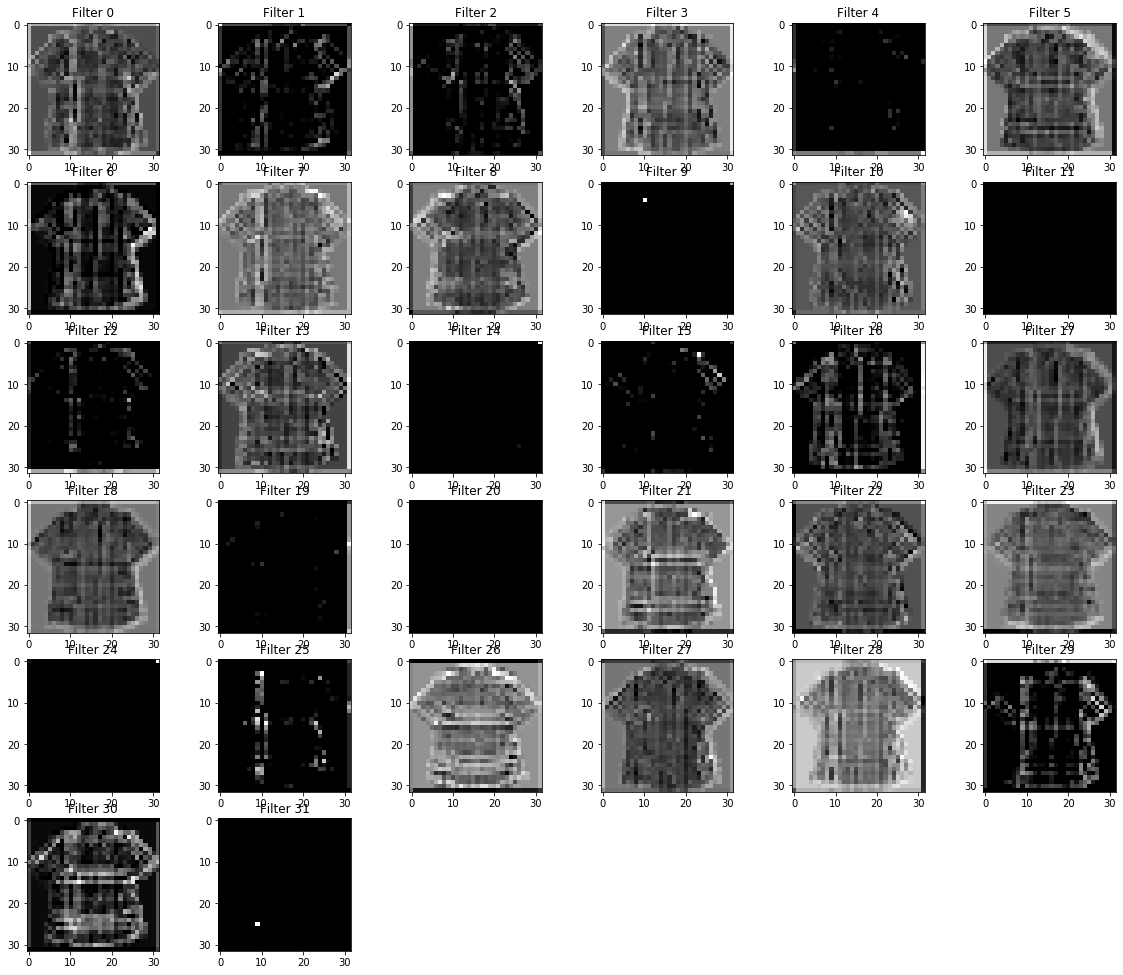

In [ ]:
getActivations(conv1_1,imageToUse)

---
# Closing the session

In [ ]:
sess.close()



---



Referred:


1. https://www.kaggle.com/ardamavi/sign-language-digits-dataset/kernels
2. https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow  
3. https://github.com/Ankush96/grad-cam.tensorflow
4. https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4

